In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("/content/bitcoin_data_lstm.csv",index_col = 'extracted_date',parse_dates = True)
df.head()

,priceUsd,priceUsd_shift,forecast
extracted_date,,,
2023-03-28,27065.670657,NaN,NaN
2023-03-29,28118.212221,1052.541564,NaN
2023-03-30,28415.304738,297.092517,NaN
2023-03-31,28240.960479,-174.344259,NaN
2023-04-01,28503.413141,262.452662,NaN


In [5]:
df.drop(columns=['priceUsd_shift','forecast'],inplace = True)
df.head()

,priceUsd
extracted_date,
2023-03-28,27065.670657
2023-03-29,28118.212221
2023-03-30,28415.304738
2023-03-31,28240.960479
2023-04-01,28503.413141


<Axes: xlabel='extracted_date'>

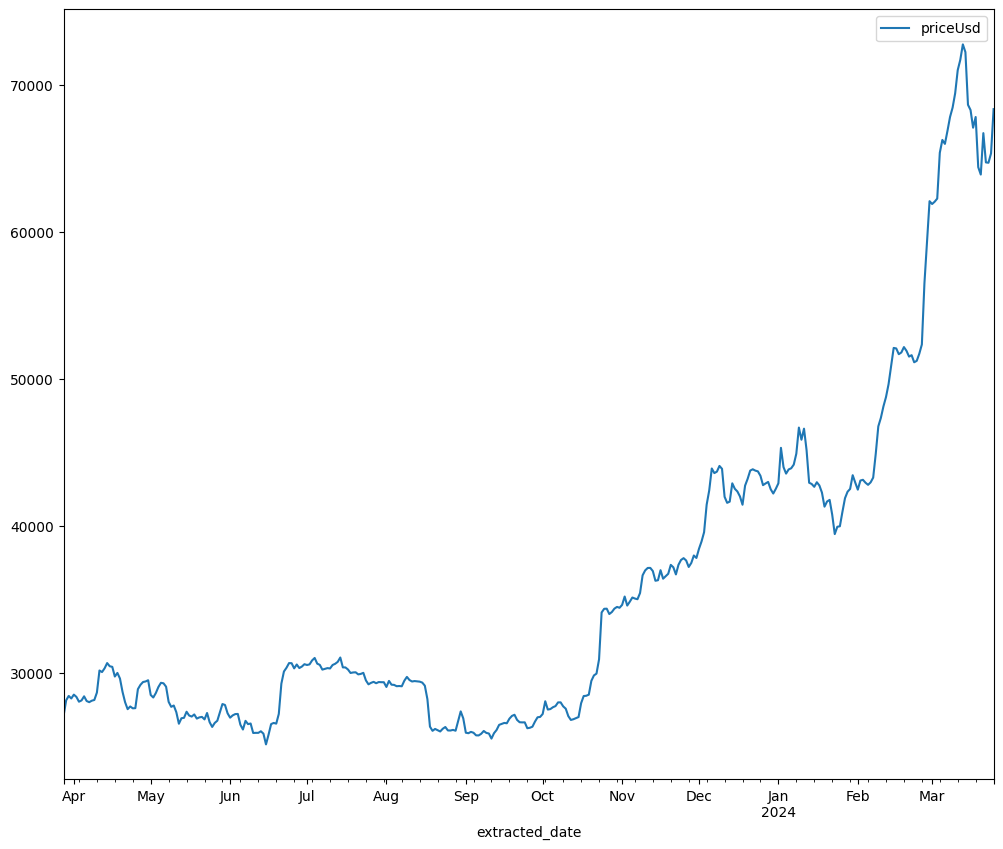

In [135]:
df.plot(figsize=(12,10))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

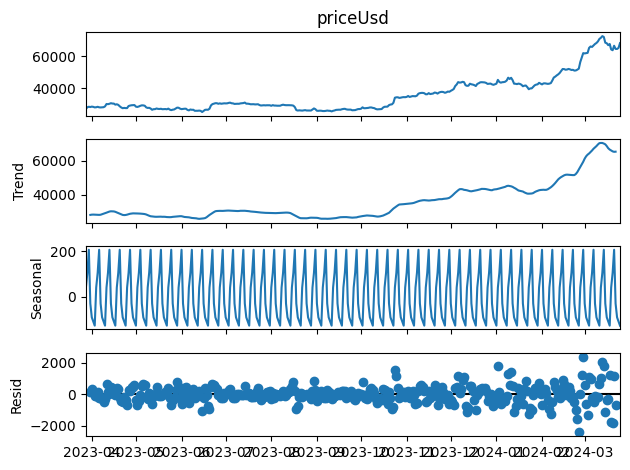

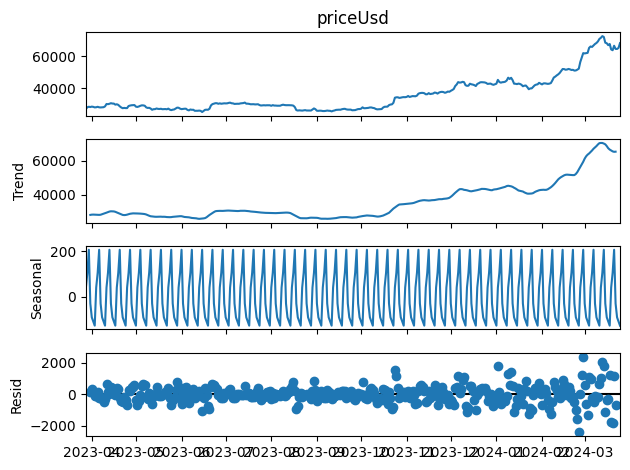

In [7]:
res = seasonal_decompose(df['priceUsd'])
res.plot()

# **Data** **Processing**

In [8]:
# Converting the price values between 0 to 1
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df=scaler.fit_transform(df)

In [10]:
scaled_df[:20]

array([[0.04088954],
       [0.06298909],
       [0.06922695],
       [0.06556635],
       [0.07107691],
       [0.06783382],
       [0.06098017],
       [0.06280397],
       [0.06866376],
       [0.06195593],
       [0.06030916],
       [0.06238946],
       [0.06345998],
       [0.07405274],
       [0.10553868],
       [0.10333499],
       [0.10863427],
       [0.11616166],
       [0.11163035],
       [0.11076933]])

In [11]:
# Splitting data into train and test
train_size = int(len(scaled_df)*0.65)
test_size = len(scaled_df) - train_size
train_data,test_data = scaled_df[:train_size,:],scaled_df[train_size:len(scaled_df),:1]

In [12]:
train_size,test_size

(236, 128)

In [13]:
len(train_data),len(test_data)

(236, 128)

In [14]:
#prepare the data matrix for the lstm model
#time-steps = 1

def create_data(data,time_step=1):
    dataX, dataY = [],[]
    for i in range(len(data)-time_step-1):
        a = data[i:(i+ time_step),0]
        dataX.append(a)
        dataY.append(data[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [15]:
time_step = 1
X_train, y_train = create_data(train_data,time_step)
X_test, y_test = create_data(test_data,time_step)

In [16]:
print(X_train.shape),print(y_train.shape)

(234, 1)
(234,)


(None, None)

In [17]:
print(X_test.shape),print(y_test.shape)

(126, 1)
(126,)


(None, None)

In [18]:
#reshaping X_train and X_test into three dimensional as it is required for LSTM model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_train.shape),print(X_test.shape)

(234, 1, 1)
(126, 1, 1)


(None, None)

# **Creating LSTM Model**

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [20]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size = 64,verbose=1)

Epoch 1/100
4/4 [==============================] - 9s 1s/step - loss: 0.0087 - val_loss: 0.2679
Epoch 2/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0067 - val_loss: 0.2519
Epoch 3/100
4/4 [==============================] - 0s 29ms/step - loss: 0.0051 - val_loss: 0.2350
Epoch 4/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0038 - val_loss: 0.2181
Epoch 5/100
4/4 [==============================] - 0s 30ms/step - loss: 0.0033 - val_loss: 0.2021
Epoch 6/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0033 - val_loss: 0.1909
Epoch 7/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0034 - val_loss: 0.1877
Epoch 8/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0033 - val_loss: 0.1912
Epoch 9/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0032 - val_loss: 0.1968
Epoch 10/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0031 - val_loss: 0.2003
Epoch 11/100
4/4 [===

# **Prediction and Model Metrics**

In [23]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

4/4 [==============================] - 0s 5ms/step


In [24]:
#Calculate RMSE
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


0.00993065387777373

In [25]:
math.sqrt(mean_squared_error(y_test,test_predict))

0.03396313986970602

In [26]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_train, train_predict)

0.0063734098082933

In [27]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, test_predict)

0.02437067778944805

In [28]:
#transform data back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


# **Plotting the Train and Test data**

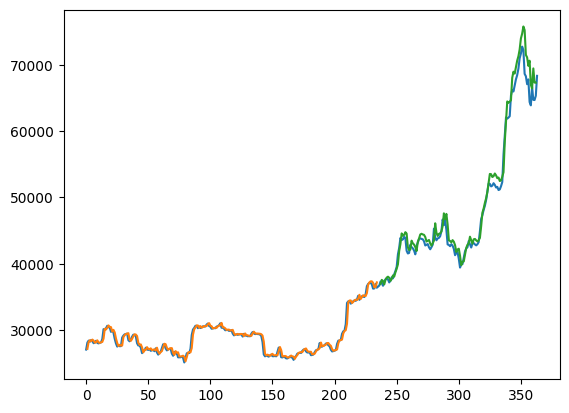

In [29]:
import numpy as np

#shift train data for plot
look_back = 1
trainPred_plot = np.empty_like(scaled_df)
trainPred_plot[:,:] = np.nan
trainPred_plot[look_back: len(train_predict) + look_back,:] = train_predict

#shift test data for plot
testPred_plot = np.empty_like(scaled_df)
testPred_plot[:,:] = np.nan
testPred_plot[len(train_predict)+(look_back*2)+1: len(scaled_df)-1,:] = test_predict

#Plot the prediction with baseline
plt.plot(scaler.inverse_transform(scaled_df))
plt.plot(trainPred_plot)
plt.plot(testPred_plot)
plt.show()

# **Predicting Crypto Price for next 10 days**

In [183]:
len(test_data)

128

In [30]:
#getting the last 10 values from test data
x_input = test_data[127:].reshape(1,-1)
x_input.shape

(1, 1)

In [31]:
#converting that into list
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [32]:
temp_input

[0.9075113188799192]

In [33]:
#prediction for next 10 days
lstm_output =[]
n_steps = 1
i=0

while(i<10):
  if(len(temp_input)>10):
    x_input = np.array(temp_input[1:])
    print(" {} Day input {}".format(i,x_input))
    x_input = x_input.reshape(1,-1)
    if len(temp_input) >= n_steps:
      x_input = x_input.reshape(1,n_steps,1)
    y = model.predict(x_input, verbose=0)
    print(" {} Day output {}".format(i,y))
    temp_input.extend(y[0].tolist())
    temp_input=temp_input[1:]
    lstm_output.extend(y.tolist())
    i=i+1

  else:
    x_input = x_input.reshape((1,n_steps,1))
    y = model.predict(x_input,verbose=0)
    print(y)
    temp_input.extend(y[0].tolist())
    print(len(temp_input))
    lstm_output.extend(y.tolist())
    i = i+1

print(lstm_output)

[[0.9673119]]
2
[[0.9673119]]
3
[[0.9673119]]
4
[[0.9673119]]
5
[[0.9673119]]
6
[[0.9673119]]
7
[[0.9673119]]
8
[[0.9673119]]
9
[[0.9673119]]
10
[[0.9673119]]
11
[[0.9673119187355042], [0.9673119187355042], [0.9673119187355042], [0.9673119187355042], [0.9673119187355042], [0.9673119187355042], [0.9673119187355042], [0.9673119187355042], [0.9673119187355042], [0.9673119187355042]]


In [35]:
day_new = np.arange(1,2)
day_pred=np.arange(2,12)

In [38]:
len(scaled_df)

364

In [37]:
df2 = scaled_df.tolist()
df2.extend(lstm_output)

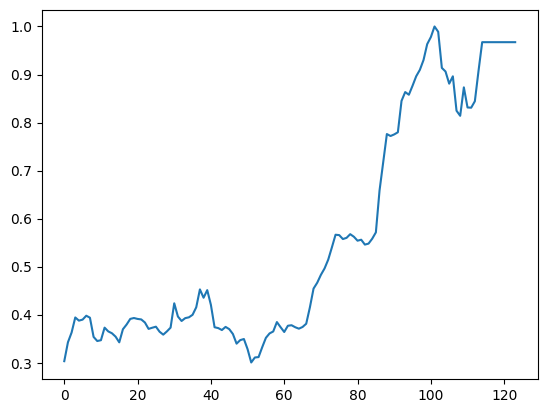

In [42]:
df2 = scaled_df.tolist()
df2.extend(lstm_output)
plt.plot(df2[250:])